Part 1: Create neigborhood dataframe

In [1]:
# import required libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
# webscrape gegraphical information and create dataframe
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M"
data = requests.get(url).text 
soup = BeautifulSoup(data,"html5lib")  

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
df = pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.shape

(103, 3)

Part 2: Add geospatial data to dataframe


In [3]:
# create dataframe with gespatial information
coordinates=pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')
coordinates.rename(columns={'Postal Code':'PostalCode'}, inplace = True)
coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [4]:
# merge datasets
toronto_all = df.merge(coordinates, on=['PostalCode'])
toronto_all.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


Part 3: Explore and cluster the neighborhoods in Toronto

In [5]:
# import required libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium

In [6]:
# explore data
print('Toronto has {} boroughs and {} neighborhoods.'.format(
        len(toronto_all['Borough'].unique()),
        toronto_all.shape[0]
    )
)

Toronto has 15 boroughs and 103 neighborhoods.


In [7]:
# nearow dataset to only include Toronto in Borough name
toronto = toronto_all[toronto_all['Borough'].str.contains('Toronto')]
toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [8]:
# define instance of geocoder
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(toronto['Latitude'], toronto['Longitude'], toronto['Borough'], toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [10]:
# request top 100 venues within 500 meters of neighborhood
#@hidden cell CLIENT_ID = 'L4G05BWQEULA4XMFXOJX1K1IVMGKG0PEHNQ0MOMNWGQRUG41'
#@hidden cell CLIENT_SECRET = 'K0MQYYXQVSS2ZZPMF2S3CT1PNHYSJXJKAVADMDKTEENIAZTK'
VERSION = '20180605'
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

# send GET request
results = requests.get(url).json()
results

# define function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# structure dataframe
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues.head()

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

# explore data
nearby_venues.head()
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))


71 venues were returned by Foursquare.


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:29: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [13]:
# define function to retrieve top 100 venues for all neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
# retrieve nearby venues per neighborhood
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Enclave of M5E
St. James Town, Cabbagetown
First Canadi

In [15]:
# explore output
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))


There are 231 uniques categories.


In [25]:
# one hot encoding the evenue categories
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
toronto_onehot.head()

# move neighborhood column to the first column
cols = toronto_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))
toronto_onehot = toronto_onehot.reindex(columns= cols)

# determine average presence of category venue in each neighborhood
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.016393,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.016393,0.049180,0.000000,0.000000,0.00,0.016393,0.016393,0.000000,0.032787,0.000000,0.000000,0.016393,0.000000,0.0000,0.000000,0.00000,0.000000,0.016393,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.016393,0.00,0.0000,0.000000,0.032787,0.000000,0.000000,0.000000,0.000000,0.016393,0.049180,0.098361,0.000000,0.000000,0.00,0.000000,0.016393,0.000000,0.016393,0.000000,0.000000,0.000000,0.016393,0.000000,0.000000,0.000000,0.000000,0.016393,0.000000,0.00,0.016393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01639

In [26]:
# print neighboorhood with top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

----Berczy Park----
          venue  freq
0   Coffee Shop  0.10
1  Cocktail Bar  0.05
2        Bakery  0.05
3      Pharmacy  0.03
4    Restaurant  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.14
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3             Gym  0.05
4      Restaurant  0.05


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3             Plane  0.06
4     Boat or Ferry  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.18
1      Sandwich Place  0.07
2  Italian Restaurant  0.05
3                Café  0.05
4        Burger Joint  0.03


----Christie----
           venue  freq
0  Grocery Store  0.25
1           Café  0.19
2           Park  0.12
3     Baby Store  0.06
4     Restaurant  0.06


----Church and Welle

In [38]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Pharmacy,Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Gym,Restaurant
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Plane,Boat or Ferry
3,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Burger Joint
4,Christie,Grocery Store,Café,Park,Baby Store,Restaurant


In [39]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

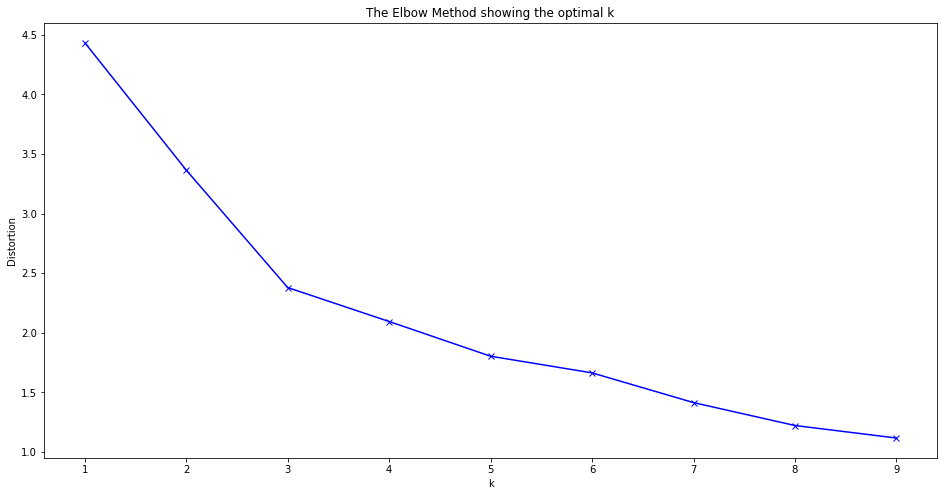

In [40]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [41]:
# Run k-means to cluster the neighborhood into 3 clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# distribution of clusters
toronto_merged['Cluster Labels'].value_counts()

1    34
0     4
2     1
Name: Cluster Labels, dtype: int64

In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
35,East York/East Toronto,0,Intersection,Convenience Store,Park,Music Venue,Mediterranean Restaurant
61,Central Toronto,0,Park,Swim School,Dim Sum Restaurant,Bus Line,Adult Boutique
83,Central Toronto,0,Park,Adult Boutique,Museum,Martial Arts School,Mediterranean Restaurant
91,Downtown Toronto,0,Park,Playground,Trail,Museum,Martial Arts School


In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Downtown Toronto,1,Coffee Shop,Café,Bakery,Park,Breakfast Spot
9,Downtown Toronto,1,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Hotel,Cosmetics Shop
15,Downtown Toronto,1,Coffee Shop,Café,Hotel,Cocktail Bar,Cosmetics Shop
19,East Toronto,1,Health Food Store,Pub,Trail,Adult Boutique,Museum
20,Downtown Toronto,1,Coffee Shop,Cocktail Bar,Bakery,Pharmacy,Restaurant
24,Downtown Toronto,1,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Burger Joint
25,Downtown Toronto,1,Grocery Store,Café,Park,Baby Store,Restaurant
30,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Thai Restaurant,Deli / Bodega
31,West Toronto,1,Pharmacy,Bakery,Brewery,Liquor Store,Bank
36,Downtown Toronto,1,Coffee Shop,Aquarium,Hotel,Café,Fried Chicken Joint
